In [1]:
import pandas as pd
import numpy as np
import matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
matplotlib.rc('xtick', labelsize=8) 
matplotlib.rc('ytick', labelsize=8)

m = ["roary","panacota","peppan","pirate","panaroo","panta","panX","panXX"]
c = list(plt.get_cmap("Set2").colors[:8])
c2 = list(plt.get_cmap("Pastel2").colors[:8])
colors=dict(zip(m,c))
colors2=dict(zip(m,c2))

def to_gb(mem):
    m = 0
    if "MB" in mem:
        m+=float(mem[:-3])/1000
    elif "GB" in mem:
        m+=float(mem[:-3])
    return m

def strip_parenthesis(s):
    return s.split(" (")[0][4:]

In [3]:
time = pd.read_csv("ecoli-cputime.txt",sep="\t")
time["cpu-hours-per-run"]=time["cpu-hours"]/time["runs"]

out = []

for n in [100,200,300,400,500]:
    #read in data
    df = pd.read_csv(f"trace/{n}.txt",sep="\t")

    #filter by completed runs
    df = df[(df["name"].str.startswith("run_")) & (df["status"]=="COMPLETED")]
    df = df[["name","peak_rss"]]

    #format data
    df.loc[:,"name"] = df["name"].apply(strip_parenthesis)
    df.loc[:,"peak_rss"] = df["peak_rss"].apply(to_gb)
    df["dataset"] = n

    out.append(df)

data = pd.concat(out)

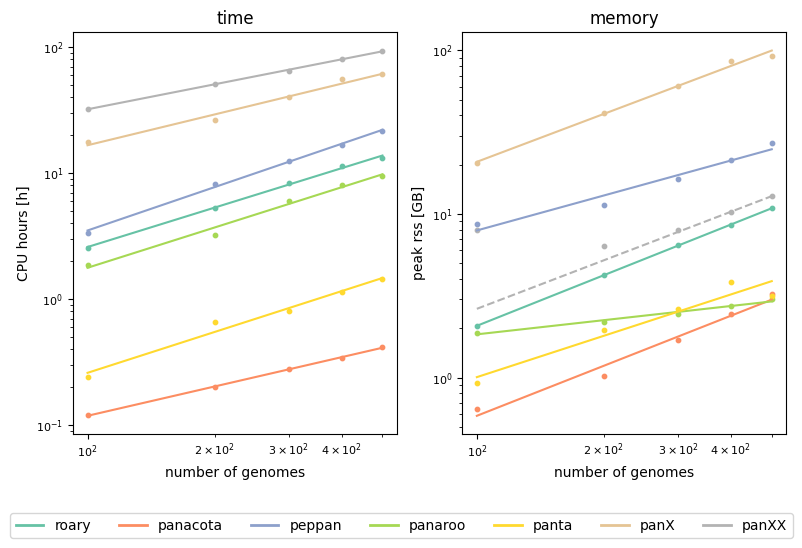

In [9]:
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(8,5))
custom_lines=[]
coeff=pd.DataFrame(columns=["cpu slope","cpu_intercept","cpu R2","memory slope","memory_intercept","memory R2"])
METHODS = ["roary","panacota","peppan","panaroo","panta","panX","panXX"]

for method in METHODS:
    custom_lines.append(Line2D([0], [0], color=colors[method], lw=2))
    X = np.asarray(time[time["method"]==method]["dataset"]).reshape(-1, 1)

    if method =="panXX":
        Y_t = np.asarray(time[time["method"]==method]["cpu-hours-per-run"])

        mem = pd.read_csv(f"trace/{method}.txt",sep="\t")[["dataset","peak_rss"]]
        mem.loc[:,"peak_rss"] = mem["peak_rss"].apply(to_gb)
        grouped = mem.groupby(by="dataset").agg('mean')
        Y_m = np.asarray(list(grouped.peak_rss.values))
        y_m = Y_m[3:]
        X_m = X[3:]

        reg_t = LinearRegression()
        reg_t.fit(np.log(X),np.log(Y_t))
        t_pred=np.exp(reg_t.predict(np.log(X)))

        reg_m = LinearRegression()
        reg_m.fit(np.log(X_m),np.log(y_m))
        m_pred=np.exp(reg_m.predict(np.log(X_m)))
        m_plot=np.exp(reg_m.predict(np.log(X)))

        coeff.loc[method] = [str(reg_t.coef_[0]),str(reg_t.intercept_),r2_score(Y_t,t_pred),str(reg_m.coef_[0]),str(reg_m.intercept_),r2_score(y_m,m_pred)]

        ax1.scatter(X,Y_t,color=colors[method],s=10)
        ax1.plot(X,t_pred,color=colors[method])

        ax2.scatter(X,Y_m,color=colors[method],s=10)
        ax2.plot(X,m_plot,color=colors[method],linestyle="dashed")

    elif method=="panX":
        Y_t = np.asarray(time[time["method"]==method]["cpu-hours-per-run"])

        mem = pd.read_csv(f"trace/{method}.txt",sep="\t")[["dataset","peak_rss"]]
        mem.loc[:,"peak_rss"] = mem["peak_rss"].apply(to_gb)
        grouped = mem.groupby(by="dataset").agg('mean')
        Y_m = np.asarray(list(grouped.peak_rss.values))

        reg_t = LinearRegression()
        reg_t.fit(np.log(X),np.log(Y_t))
        t_pred=np.exp(reg_t.predict(np.log(X)))

        reg_m = LinearRegression()
        reg_m.fit(np.log(X),np.log(Y_m))
        m_pred=np.exp(reg_m.predict(np.log(X)))

        coeff.loc[method] = [str(reg_t.coef_[0]),str(reg_t.intercept_),r2_score(Y_t,t_pred),str(reg_m.coef_[0]),str(reg_m.intercept_),r2_score(Y_m,m_pred)]

        ax1.scatter(X,Y_t,color=colors[method],s=10)
        ax1.plot(X,t_pred,color=colors[method])

        ax2.scatter(X,Y_m,color=colors[method],s=10)
        ax2.plot(X,m_pred,color=colors[method])

    else:
        mem = data[data["name"]==method][["dataset","peak_rss"]]
        grouped = mem.groupby(by="dataset").agg('mean')
        X = grouped.index.values.reshape(-1, 1)
        Y_t = np.asarray(time[time["method"]==method]["cpu-hours-per-run"])
        Y_m = np.asarray(list(grouped.peak_rss.values))

        reg_t = LinearRegression()
        reg_t.fit(np.log(X),np.log(Y_t))
        t_pred=np.exp(reg_t.predict(np.log(X)))

        reg_m = LinearRegression()
        reg_m.fit(np.log(X),np.log(Y_m))
        m_pred=np.exp(reg_m.predict(np.log(X)))

        coeff.loc[method] = [str(reg_t.coef_[0]),str(reg_t.intercept_),r2_score(Y_t,t_pred),str(reg_m.coef_[0]),str(reg_m.intercept_),r2_score(Y_m,m_pred)]

        ax1.scatter(X,Y_t,color=colors[method],s=10)
        ax1.plot(X,t_pred,color=colors[method])

        ax2.scatter(X,Y_m,color=colors[method],s=10)
        ax2.plot(X,m_pred,color=colors[method])


ax1.set_title("time")
ax1.set_ylabel("CPU hours [h]")
ax1.set_xlabel("number of genomes")

ax2.set_title("memory")
ax2.set_ylabel("peak rss [GB]")
ax2.set_xlabel("number of genomes")

ax1.set_yscale('log')
ax1.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xscale('log')

lgd = fig.legend(custom_lines,METHODS,ncols=len(custom_lines),loc="outside lower center",bbox_to_anchor=(0,-.1,1,0))
fig.tight_layout()

fig.savefig("bench-overview.png",bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)
plt.show()


In [10]:
coeff

,cpu slope,cpu_intercept,cpu R2,memory slope,memory_intercept,memory R2
roary,1.0384912071369192,-3.8293294780340705,0.990825,1.0286848280286642,-4.009705507499698,0.999787
panacota,0.7724133135206849,-5.686474705489516,0.997729,1.0161839929951457,-5.218748382958715,0.979995
peppan,1.1421615103229574,-4.004556936770089,0.997118,0.7103301093166723,-1.2008274925096751,0.956706
panaroo,1.0606083165041236,-4.309885422500696,0.985974,0.2878418527035685,-0.7177031744280901,0.979716
panta,1.0762837530114067,-6.3010305621023575,0.980273,0.8397743141356196,-3.862040661518011,0.804161
panX,0.8110382260980568,-0.9228528435020094,0.977550,0.9735742377378097,-1.4469993214116452,0.977284
panXX,0.6577759113560251,0.43986427739639433,0.998246,0.9857285036226322,-3.5722612945097043,1.000000


In [36]:
limits = {}
for method,data in coeff.iterrows():
    l_t = np.exp((np.log(1000)-float(data["cpu_intercept"]))/float(data["cpu slope"]))
    l_m = np.exp((np.log(500)-float(data["memory_intercept"]))/float(data["memory slope"]))
    limits[method] = [int(l_t),int(l_m)]

print(limits)

{'roary': [30918, 20727], 'panacota': [12055602, 76977], 'peppan': [14102, 34180], 'panaroo': [39206, 28803138200], 'panta': [213755, 162630], 'panX': [15600, 2616], 'panXX': [18638, 20507]}
